# Introduction
This notebook introduces a novel approach to data preparation for our RNN model. By reshaping the data to incorporate 20 sequential frames for each sensor, corresponding to 20 timesteps, we aim to enhance the model's ability to interpret sign language. Additionally, we explore the use of another model to visualize the activations of each layer in the RNN, thereby gaining insights into the layers' impact on the model's performance.


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping
import joblib
from keras.layers import SimpleRNN, Bidirectional, BatchNormalization
from keras.layers import TimeDistributed, GlobalAveragePooling1D
from keras.models import Model
import matplotlib.pyplot as plt


df_1 = pd.read_csv('../dataset/sensor_data_badr.csv')
df_2 = pd.read_csv('../dataset/sensor_data_mouad.csv')
df_3 = pd.read_csv('../dataset/sensor_data_ismail.csv')
# Concatenate the three dataframes
df = pd.concat([df_1, df_2, df_3], ignore_index=True)

# number of rows and columns
print(df.shape)

# Convert all feature columns to numeric and set non-convertible values to NaN
for col in df.columns[:-1]:  # Excluding the last column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Removing rows with NaN values
df.dropna(inplace=True)

# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values   # Only the last column


# Scale the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


(1791, 441)


## Data Reshaping for Enhanced RNN Input
In this section, we reshape our dataset to align with the RNN's requirements for sequential data. This involves organizing the data into 20 timesteps, each representing a frame in the sensor data sequence. This restructuring is hypothesized to improve the model's ability to process and interpret the temporal aspects of sign language.


In [12]:
# Reorganize data for RNN
num_samples = X.shape[0]
num_timesteps = 20
num_features = 22
num_sensors_per_frame = int(X.shape[1] / num_timesteps)

# Reshape X for RNN input
X_reshaped = np.empty((num_samples, num_timesteps, num_features))
for i in range(num_timesteps):
    for j in range(num_sensors_per_frame):
        X_reshaped[:, i, j] = X[:, i * num_sensors_per_frame + j]

print(X_reshaped[0, :, 0])

[0.47826087 0.76119403 0.836      0.72156863 1.         0.29008278
 0.37595628 0.39661972 0.75728155 0.51617076 0.82222222 0.828125
 0.69803922 0.82352941 0.80392157 0.45107904 0.6607063  0.44405434
 0.75       0.09294013]


In [13]:

# Encode the labels
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))


c:\Users\lenovo\Desktop\ENSIMAG\IA & IoT\magic-gloves\magic-gloves-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Model Adaptation and Training
Following the data reshaping, we adapt and train our RNN model to work with this new data structure. The model is expected to make predictions based on all timesteps and average these results to yield a single, consolidated prediction.

In adapting our model to the newly structured data, several key changes were made:

1. **Input Shape Adjustment**: The input layer of our RNN model was modified to accommodate the 20 timesteps, each representing a frame in the sensor data sequence. This ensures that the model can effectively process the temporal sequence of the sensor data.

2. **Output Processing**: Since the model now provides predictions for each timestep, we added a mechanism to consolidate these multiple predictions into a single, final output. This involves averaging the predictions across all timesteps, thereby synthesizing the information gathered throughout the sequence into a cohesive conclusion.



In [14]:

# Define the RNN model
model_rnn = Sequential()
model_rnn.add(Bidirectional(SimpleRNN(30, activation='relu', return_sequences=True), input_shape=(num_timesteps, num_features)))
model_rnn.add(BatchNormalization())
model_rnn.add(SimpleRNN(32, activation='relu', return_sequences=True))
model_rnn.add(Dropout(0.3))
model_rnn.add(TimeDistributed(Dense(16, activation='relu')))
model_rnn.add(TimeDistributed(Dense(y_encoded.shape[1], activation='softmax')))


# Add a GlobalAveragePooling1D layer to average the predictions from each timestep
model_rnn.add(GlobalAveragePooling1D())

In [15]:

# Compile the model with categorical_crossentropy loss function
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add EarlyStopping as a callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Now use X_reshaped for splitting and training
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Train the model
model_rnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
45/45 [==============================] - 4s 21ms/step - loss: 1.6409 - accuracy: 0.3792 - val_loss: 1.8314 - val_accuracy: 0.1480
Epoch 2/100
45/45 [==============================] - 0s 8ms/step - loss: 1.0495 - accuracy: 0.7388 - val_loss: 1.2893 - val_accuracy: 0.5168
Epoch 3/100
45/45 [==============================] - 0s 9ms/step - loss: 0.5828 - accuracy: 0.8198 - val_loss: 1.3114 - val_accuracy: 0.5810
Epoch 4/100
45/45 [==============================] - 0s 9ms/step - loss: 0.4115 - accuracy: 0.8980 - val_loss: 0.2976 - val_accuracy: 0.9469
Epoch 5/100
45/45 [==============================] - 0s 10ms/step - loss: 0.2739 - accuracy: 0.9560 - val_loss: 0.2183 - val_accuracy: 0.9358
Epoch 6/100
45/45 [==============================] - 0s 8ms/step - loss: 0.2243 - accuracy: 0.9616 - val_loss: 0.2187 - val_accuracy: 0.9441
Epoch 7/100
45/45 [==============================] - 0s 8ms/step - loss: 0.2109 - accuracy: 0.9658 - val_loss: 0.0918 - val_accuracy: 0.9832
Epoch 8/100

# Layer Activation Visualization
To understand the contribution of each layer in the RNN towards the model's performance, we utilize another model to visualize the activations of these layers. This visualization aims to provide deeper insights into the functioning and efficacy of our RNN model.

The visualization figure generated by the layer activation model provide a graphical representation of how different layers in the RNN process the input data. Here's how to interpret these figures:

1. **Colors**: The color intensity in each cell of the visualization typically represents the activation level of a neuron. More intense colors might indicate higher activation levels, suggesting that those neurons are responding strongly to certain features in the data.

2. **X-Axis**: The x-axis represents the different units or neurons in a particular layer of the RNN. Each unit may respond to different features or patterns in the input data.

3. **Y-Axis**: The y-axis corresponds to the timesteps in our input data. In our case, with 20 timesteps, each point on the y-axis represents the activation of neurons at a specific frame in the sequence.

4. **Interpreting Patterns**: By observing patterns across the axes, we can infer which features (as captured by specific neurons) are more significant at different stages (timesteps) of the input sequence. This can provide insights into what the model is 'paying attention to' at each step and how it is processing the temporal information.


1/1 [==============================] - 0s 355ms/step


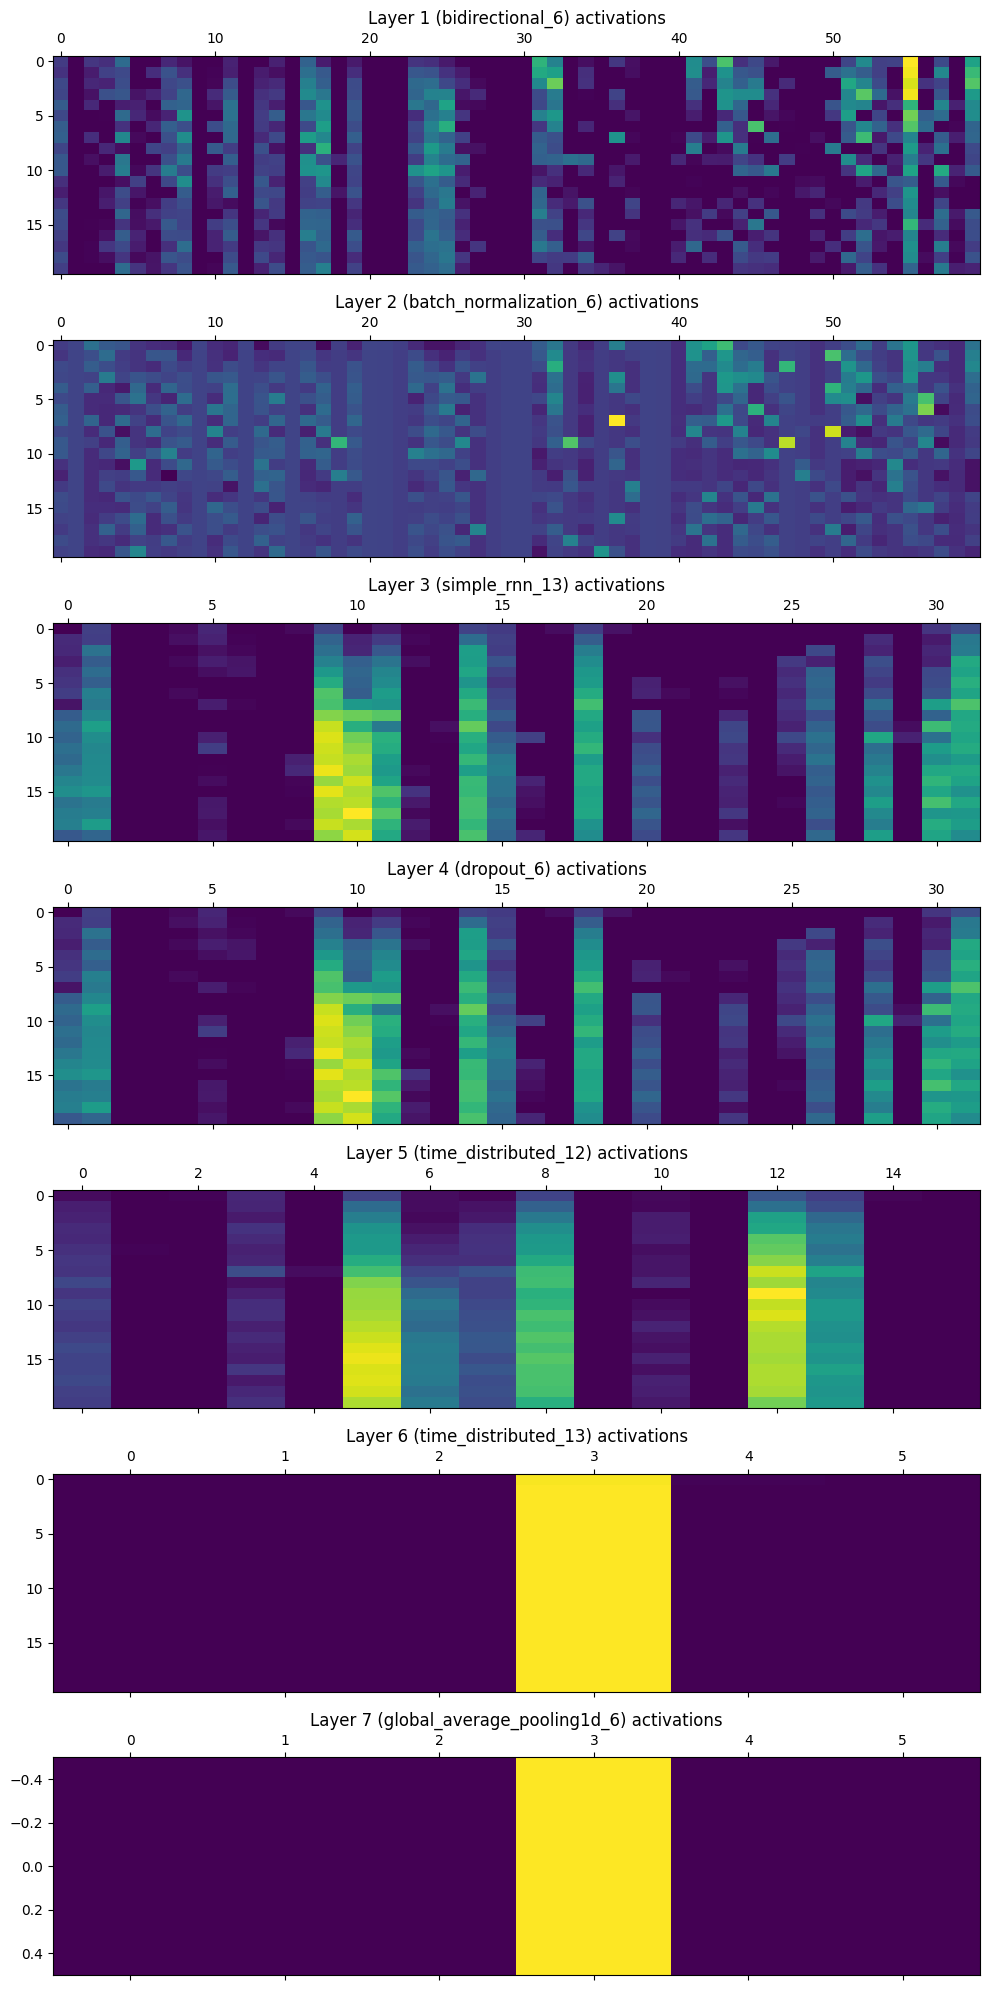

In [16]:
# Create a new model that outputs the activations of the first SimpleRNN layer

# Choose some input data
input_data = X_test[0:1]


# Initialize a figure for the plot
fig, axs = plt.subplots(len(model_rnn.layers), figsize=(10, 20))

for i, layer in enumerate(model_rnn.layers):
    if not isinstance(layer, Dense):  # Skip Dense layers
        # Create a new model that outputs the activations of the current layer
        activation_model = Model(inputs=model_rnn.input, outputs=layer.output)

        # Compute the activations
        activations = activation_model.predict(input_data)

        # Check if the activations are 2D or 3D
        if activations.ndim == 3:
            # 3D activations, plot as is
            axs[i].matshow(activations[0, :, :], aspect='auto')
        else:
            # 2D activations, plot directly
            axs[i].matshow(activations, aspect='auto')

        axs[i].set_title(f'Layer {i+1} ({layer.name}) activations')

# Show the plot
plt.tight_layout()
plt.show()

# Conclusion

Through the restructuring of our dataset and the adaptation of the RNN model, we have taken significant steps in enhancing the model's ability to interpret sign language. The data reshaping to 20 timesteps aligns more closely with the sequential nature of sign language, potentially improving the model's accuracy. The visualization of layer activations offers a window into the inner workings of the RNN, providing valuable insights into which features and timesteps are most influential in the model's predictions. These advancements underscore the importance of continuous innovation and adaptation in the field of AI, especially in applications as complex and impactful as sign language translation.
